In [1]:
if 'google.colab' in str(get_ipython()):
    !pip uninstall tensorflow -y
    !pip install tensorflow==2.3.1 tensorflow-quantum neptune-client
    !rm -rf quantum-gans
    !git clone https://github.com/WiktorJ/quantum-gans
    !cd quantum-gans; pip install .
    neptun_token = "" # put manually for the time being
else:
    import subprocess
    def get_var(varname):
        CMD = 'echo $(source ~/.bash_profile; echo $%s)' % varname
        p = subprocess.Popen(CMD, stdout=subprocess.PIPE, shell=True, executable='/bin/bash')
        return p.stdout.readlines()[0].strip()
    neptun_token = get_var('NEPTUNE_API_TOKEN').decode("utf-8") 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
use_neptune = False

In [4]:
import neptune
import tensorflow as tf
import random

import io
import cirq
import numpy as np
import statistics as st
from matplotlib import pyplot as plt
from collections import defaultdict
from qsgenerator import circuits
from qsgenerator.quwgans import circuits as quwgans_circuits
from qsgenerator.quwgans.circuits import get_discriminator
from qsgenerator.quwgans.training import Trainer
from qsgenerator.phase.circuits import PhaseCircuitBuilder
from qsgenerator.phase.string_order_parameters import measure_szy_pauli_string, measure_s1_pauli_string
from qsgenerator.states.butterfly_circuits import ButterflyCircuitBuilder
from qsgenerator.quwgans.real_expectations_provider import PrecomputedExpectationsProvider, \
    Interpolation1DExpectationsProvider, WassersteinGanExpectationProvider, ExpectationProviderType
from qsgenerator.states.simple_rotation_generators import get_fixed_random_rotation_provider
from qsgenerator.evaluators.circuit_evaluator import CircuitEvaluator
from qsgenerator.phase.analitical import get_theta_v, get_theta_w, get_theta_r, get_g_parameters_provider


In [5]:
generator_layers = 3
data_bus_size = 7
rank = 1
real_circuit_type = 'phase'
generic_generator = False
zxz = False
all_gates_parametrized = False
expectation_provider_type = ExpectationProviderType.ONLY_KNOWN
g_values = [-0.5]
# known_g_values = list(range(32))
known_g_values = [np.round(el, 1) for el in np.linspace(-1,0,11)]
# known_g_values = [-1, -0.75, -0.5, -0.25, 0]
if expectation_provider_type == ExpectationProviderType.WGAN:
        gen_input_dim = 16
        hidden_dim = [32, 64]
        penalty_factor = 10
        gan_epochs = 10000
        batch_size = 8
known_g_values

[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0]

In [6]:
data_qubits = qubits = cirq.GridQubit.rect(1, data_bus_size)

In [7]:
if real_circuit_type == 'butterfly':
    real, real_symbols = ButterflyCircuitBuilder().build(qubits=qubits)
    real_values_provider = get_fixed_random_rotation_provider(len(real_symbols))
else:
    builder = PhaseCircuitBuilder(all_gates_parametrized=False, g_positive=False)
    real, real_symbols, symbols_dict_real = builder.build_ground_state_circuit(qubits=data_qubits)
    real_values_provider = get_g_parameters_provider()

In [8]:
if generic_generator:
    gen, gs = circuits.build_circuit(generator_layers, data_qubits, "g")
    symbols_dict_gen = {}
else:
    if real_circuit_type == 'butterfly':
        gen, gs = ButterflyCircuitBuilder("g").build(qubits=qubits)
    else:
        builder = PhaseCircuitBuilder(all_gates_parametrized=all_gates_parametrized)
        gen, gs, symbols_dict_gen = builder.build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)

In [9]:
print("REAL GROUND STATE")
real

REAL GROUND STATE


(0, 0): ───H───@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │
(0, 1): ───────X───Z───Ry(theta_r)───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                   │                                       │
(0, 2): ─────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                   │                                       │
(0, 3): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                   │                                       │
(0, 4): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                                                                   │                                       │
(0, 5): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────
                                                                                                                                                                                                                                                                                                                                                                                   │                                       │
(0, 6): ──────────────────────────────────────────────────────────────────────────────────

In [10]:
print("GENERATOR")
gen

GENERATOR


(0, 0): ───H───@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │
(0, 1): ───────X───Z───Ry(theta0)───X────────────@───X─────────────────────────────────@───X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                 │                                     │
(0, 2): ────────────────────────────Ry(theta3)───X───X───Ry(theta4)───X───Ry(theta1)───X───X───Ry(theta2)───X───X────────────@───X─────────────────────────────────@───X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                             │                                     │
(0, 3): ────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta7)───X───X───Ry(theta8)───X───Ry(theta5)───X───X───Ry(theta6)───X───X─────────────@───X──────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                          │                                      │
(0, 4): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta11)───X───X───Ry(theta12)───X───Ry(theta9)───X───X───Ry(theta10)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                                                         │                                       │
(0, 5): ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta15)───X───X───Ry(theta16)───X───Ry(theta13)───X───X───Ry(theta14)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────
                                                                                                                                                                                                                                                                                                                                                                         │                                       │
(0, 6): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [11]:
opt = tf.keras.optimizers.Adam(0.01, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [12]:
def get_expectation_provider(real, real_symbols, known_g_values, real_values_provider):
    precomputed_expectation_provider = PrecomputedExpectationsProvider(real,
                                                                       real_symbols,
                                                                       known_g_values,
                                                                       real_values_provider,
                                                                       get_discriminator(real))
    if expectation_provider_type == ExpectationProviderType.ONLY_KNOWN:
        return precomputed_expectation_provider
    elif expectation_provider_type == ExpectationProviderType.INTERPOLATION1D:
        return Interpolation1DExpectationsProvider(precomputed_expectation_provider)
    elif expectation_provider_type == ExpectationProviderType.WGAN:
        return WassersteinGanExpectationProvider(precomputed_expectation_provider, gen_input_dim, hidden_dim, penalty_factor, gan_epochs, batch_size)

In [13]:
real_expectations_provider = get_expectation_provider(real, real_symbols, known_g_values, real_values_provider)

In [14]:
trainer = Trainer(real, 
                  real_symbols,
                  gen,
                  gs,
                  g_values,
                  real_values_provider,
                  real_expectations_provider,
                  rank=rank,
                  use_neptune=use_neptune)

In [15]:
epochs = 801
gen_iteration = 1
snapshot_interval_epochs = 100

In [16]:
def start_neptune_experiment(trainer, gen, description=None):
    if use_neptune:
        neptune.init(project_qualified_name='wiktor.jurasz/thesis-em2', api_token=neptun_token)
        neptun_params = {
            'generator_layers': generator_layers,
            'size':  data_bus_size,
            'rank': rank,
            'real_circuit_type': real_circuit_type,
            'generic_generator': generic_generator,
            'zxz': zxz,
            'all_gates_parametrized': all_gates_parametrized,
            'g_values': g_values,
            'expectation_provider_type': expectation_provider_type,
            'known_g_values': known_g_values,
            'gen_iteration': gen_iteration,
            'epochs': epochs
        }
        if expectation_provider_type == ExpectationProviderType.WGAN:
            gan_params = {
                'gen_input_dim': gen_input_dim,
                'hidden_dim': hidden_dim,
                'penalty_factor': penalty_factor,
                'gan_epochs': gan_epochs,
                'batch_size': batch_size
            }
            neptun_params = {**neptun_params, **gan_params}
        neptune.create_experiment(name=None, description=description, params=neptun_params)
        neptune.log_artifact(io.StringIO(str(gen)), "gen.txt")
        neptune.log_artifact(io.StringIO(str(([(el[0].numpy(), el[1], list(el[2].numpy())) for el in trainer.gen_weights]))), 'init_gen_weights.txt')

In [17]:
start_neptune_experiment(trainer, gen)

<Figure size 432x288 with 0 Axes>

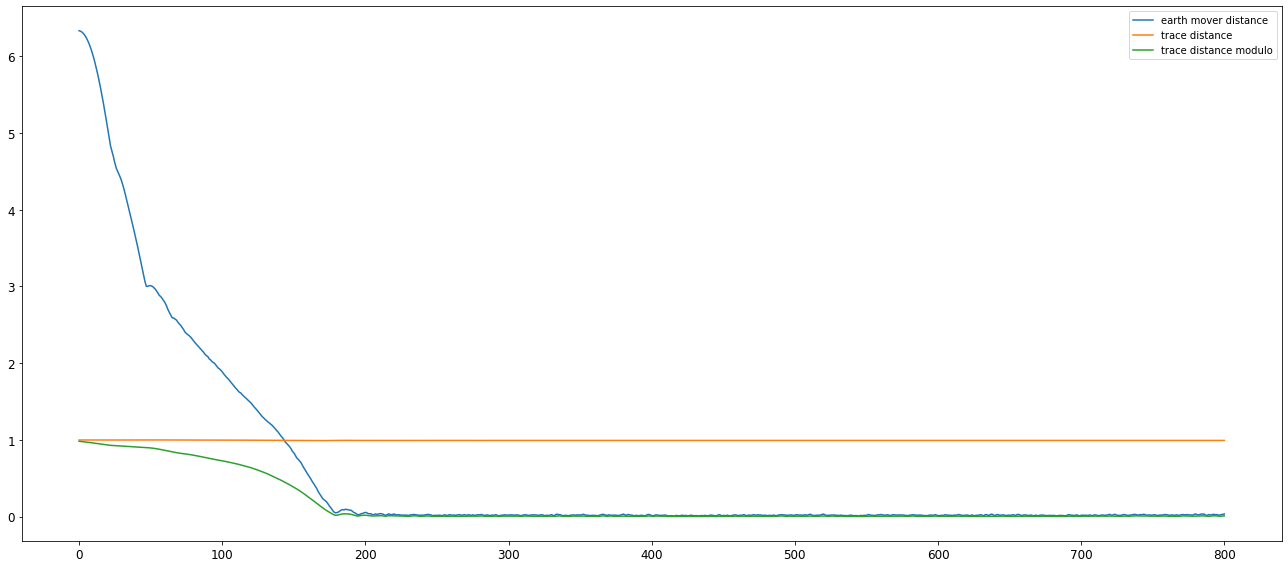

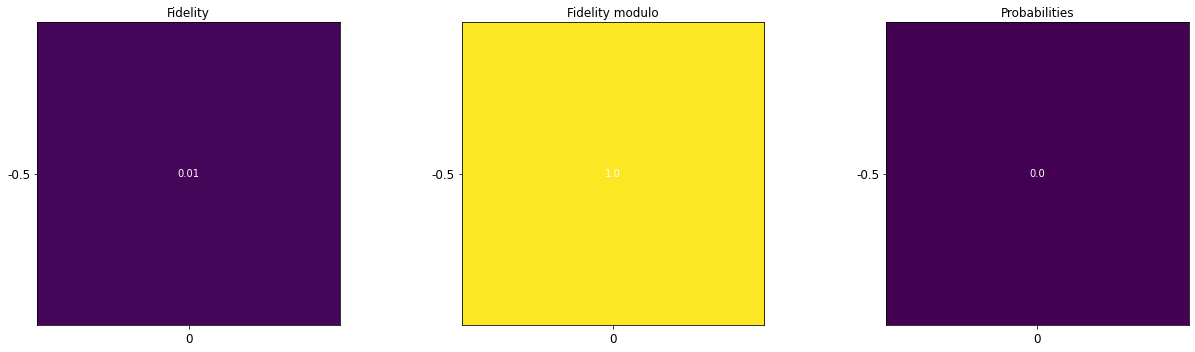

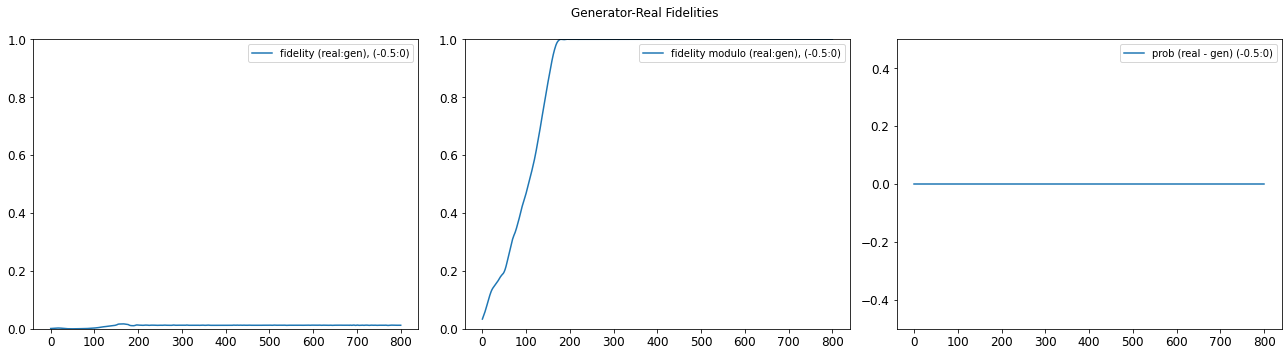

----------------------------------------------------
Epoch 800:  EM distance = 0.03620922792459104, trace distance = 0.9938646147546593, abs trace distance = 0.011064086231920157
h=Y((0, 0))*Y((0, 1)), w=0.9999999999723814, e=0.0020722681656479836
h=Z((0, 2))*Z((0, 3)), w=0.9999999999977861, e=0.010669618844985962
h=Z((0, 4))*X((0, 5)), w=-0.9999999999979359, e=-0.012179804733023047
h=Z((0, 6)), w=0.9999999999996645, e=0.011287536181043833
-------------------------------------
----------- TRAINING DONE -----------


In [18]:
json_result = trainer.train(opt, epochs, gen_iteration, snapshot_interval_epochs, plot=True)

In [19]:
if use_neptune:
    neptune.stop()

In [20]:
def compute_known_states_stats(tra, g_list):
       return compute_states_stats(
        lambda g: tra.real_evaluator.get_state_from_params(labels=g)[1],
        lambda g: tra.real_evaluator.get_state_from_params(labels=g)[1],
        g_list,
        g_list
    ) 

def compute_generated_states_stats(tra, g_list):
    return compute_states_stats(
        lambda g: tra.gen_evaluator.get_state_from_params()[1],
        lambda g: tra.real_evaluator.get_state_from_params(labels=g)[1],
        ["GENERATED"],
        g_list
    )

def compute_states_stats(state_prov1, state_prov2, g_list1, g_list2):
    stats = {
        'min_fidelity': 1,
        'min_fidelity_tuple': (None, None),
        'max_fidelity': 0,
        'max_fidelity_tuple': (None, None),
        'average_fidelity': None,
        'std_fidelity': None
    }
    fids = []
    for g1 in g_list1:
        for g2 in g_list2:
            if g1 != g2:
                state1 = state_prov1(g1)
                state2 = state_prov2(g2)
                fid = cirq.fidelity(state1, state2)
                fids.append(fid)
                if fid < stats['min_fidelity']:
                    stats['min_fidelity'] = fid
                    stats['min_fidelity_tuple'] = (g1, g2)
                if fid > stats['max_fidelity']:
                    stats['max_fidelity'] = fid
                    stats['max_fidelity_tuple'] = (g1, g2)
                
    stats['average_fidelity'] = st.mean(fids)
    stats['std_fidelity'] = st.stdev(fids)
    return stats

In [21]:
compute_known_states_stats(trainer, known_g_values)

{'min_fidelity': 0.015624973922978791,
 'min_fidelity_tuple': (-1.0, 0.0),
 'max_fidelity': 0.995847729801028,
 'max_fidelity_tuple': (-1.0, -0.9),
 'average_fidelity': 0.6673639278890247,
 'std_fidelity': 0.3216513148698793}

In [22]:
compute_generated_states_stats(trainer, known_g_values)

{'min_fidelity': 0.08742580845779813,
 'min_fidelity_tuple': ('GENERATED', 0.0),
 'max_fidelity': 0.9998781718168317,
 'max_fidelity_tuple': ('GENERATED', -0.5),
 'average_fidelity': 0.8132607299343633,
 'std_fidelity': 0.2720127331748753}

In [23]:
from scipy.optimize import linprog
def get_em_distance(W, H, t):
    traces = (t.get_all_generator_expectations(H).numpy() - t.get_real_expectation(H)).flatten()
    return sum(x * y for x, y in zip(W, traces))

def get_em_distance_real(t1, t2):
    traces = (t1.get_real_expectation(t1.disc_hamiltonians) - t2.get_real_expectation(t2.disc_hamiltonians)).flatten()
    res = linprog(-traces, A_ub=t1.A, b_ub=t1.b, bounds=(0, 1))
    tt = [traces[i] for i in range(len(t1.disc_hamiltonians)) if res.x[i] > 1.e-5]
    res2 = [res.x[i] for i in range(len(res.x)) if res.x[i] > 1.e-5]
    return sum(x * y for x, y in zip(res2, tt))

def get_em_distance2(W, H, t):
    traces = (t.get_all_generator_expectations(t.disc_hamiltonians).numpy() -
              t.get_real_expectation(t.disc_hamiltonians)).flatten()
    res = linprog(-traces, A_ub=t.A, b_ub=t.b, bounds=(0, 1))
    tt = [traces[i] for i in range(len(t.disc_hamiltonians)) if res.x[i] > 1.e-5]
    res2 = [res.x[i] for i in range(len(res.x)) if res.x[i] > 1.e-5] 
    return sum(x * y for x, y in zip(res2, tt)), res2, tt

def plot_em_distance_between_real():
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))
    # g=-0.4
    # W, H = list(zip(*g_dict[g].last_run_generator_weights[-1].disc_w_h.items()))
    # get_em_distance(W, H, g_dict[-0.5]), g_dict[g].last_run_generator_weights[-1].em_distance
    g_values2 = [np.round(el, 1) for el in np.linspace(-1,0,11)]
    tr = {}
    for g in g_values2:
        tr[g] = Trainer(real, real_symbols, gen, gs, [g], real_values_provider, rank=rank, use_neptune=False)
    x = g_values2
    for g1 in g_values2:
        tmp_res = []
        for g2 in g_values2:
            tmp_res.append(get_em_distance_real(tr[g1], tr[g2]))
        axes.plot(x, tmp_res,label=g1)
    axes.legend()
    plt.show()

TypeError: __init__() missing 1 required positional argument: 'real_expectations_provider'

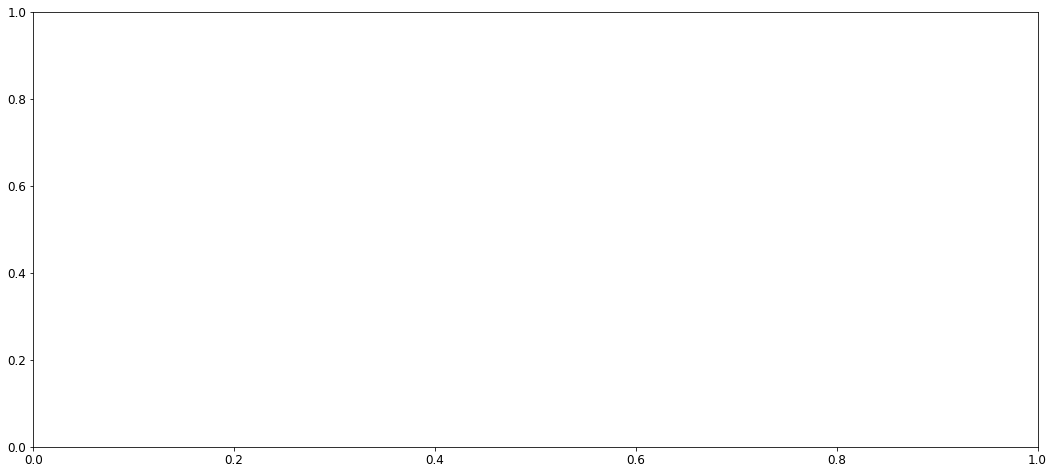

In [24]:
plot_em_distance_between_real()

In [ ]:
use_neptune = False
generator_layers = 3
data_bus_size = 6
rank = 1
real_circuit_type = 'butterfly'
generic_generator = False
zxz = False
all_gates_parametrized = False
expectation_provider_type = ExpectationProviderType.WGAN
known_g_values = list(range(32))
g_values = [1, 2, 3]
if expectation_provider_type == ExpectationProviderType.WGAN:
        gen_input_dim = 16
        hidden_dim = [32, 64]
        penalty_factor = 10
        gan_epochs = 5000
        batch_size = 8
        
gen_iteration = 2
snapshot_interval_epochs = 200
epochs = 1201

In [ ]:
def run_for_g_values(g_values,
                     real,
                     real_symbols,
                     gen,
                     gs,
                     real_values_provider,
                     rank):    
    for g in g_values:
        trainers[g] = Trainer(real, 
                              real_symbols, 
                              gen, 
                              gs, 
                              [g], 
                              real_values_provider, 
                              real_expectations_provider,
                              rank=rank, 
                              use_neptune=use_neptune)

        opt = tf.keras.optimizers.Adam(0.01, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

        start_neptune_experiment(trainers[g], gen)

        json_result =  trainers[g].train(opt, epochs, gen_iteration, snapshot_interval_epochs, plot=True)
        trainers[g] = json_result
    
        if use_neptune:
            neptune.stop()
    return trainers

In [ ]:
data_qubits = qubits = cirq.GridQubit.rect(1, data_bus_size)
trainers = {}
if real_circuit_type == 'butterfly':
    real, real_symbols = ButterflyCircuitBuilder().build(qubits=qubits)
    real_values_provider = get_fixed_random_rotation_provider(len(real_symbols))
else:
    builder = PhaseCircuitBuilder(all_gates_parametrized=False)
    real, real_symbols, symbols_dict_real = builder.build_ground_state_circuit(qubits=data_qubits)
    real_values_provider = get_g_parameters_provider()

if generic_generator:
    gen, gs = circuits.build_circuit(generator_layers, data_qubits, "g")
    symbols_dict_gen = {}
else:
    builder = PhaseCircuitBuilder(all_gates_parametrized=all_gates_parametrized)
    gen, gs, symbols_dict_gen = builder.build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)
    
real_expectations_provider = get_expectation_provider(real, real_symbols, known_g_values, real_values_provider)

In [ ]:
trainers = run_for_g_values(g_values)

In [ ]:
gen_iteration = 2
snapshot_interval_epochs = 200
epochs = 801
training_result = {}
trainer_dict = {}
for j, g in enumerate(g_values):
    trainer_by_size = {}
    result_by_size = {}
    training_result[(j, g)] = result_by_size
    trainer_dict[(j, g)] = trainer_by_size
    for i, data_bus_size in enumerate(sizes):
        data_qubits = qubits = cirq.GridQubit.rect(1, data_bus_size)
        
        if real_circuit_type == 'butterfly':
            real, real_symbols = ButterflyCircuitBuilder().build(qubits=qubits)
            real_values_provider = get_fixed_random_rotation_provider(len(real_symbols))
        else:
            builder = PhaseCircuitBuilder(all_gates_parametrized=False)
            real, real_symbols, symbols_dict_real = builder.build_ground_state_circuit(qubits=data_qubits)
            real_values_provider = get_g_parameters_provider()

        if generic_generator:
            gen, gs = circuits.build_circuit(generator_layers, data_qubits, "g")
            symbols_dict_gen = {}
        else:
            builder = PhaseCircuitBuilder(all_gates_parametrized=all_gates_parametrized)
            gen, gs, symbols_dict_gen = builder.build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)
        real_expectations_provider = get_expectation_provider(real, real_symbols, known_g_values, real_values_provider)

        trainer_by_size[(i, data_bus_size)] = Trainer(real, 
                                                      real_symbols, 
                                                      gen, 
                                                      gs, 
                                                      [g], 
                                                      real_values_provider, 
                                                      real_expectations_provider,
                                                      rank=rank, 
                                                      use_neptune=False)
        
        opt = tf.keras.optimizers.Adam(0.01, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
                
        start_neptune_experiment(trainer_by_size[(i, data_bus_size)])

        json_result = trainer_by_size[(i, data_bus_size)].train(opt, epochs, gen_iteration, snapshot_interval_epochs, plot=True)
        training_result[(i,data_bus_size)] = json_result
        
        if use_neptune:
            neptune.stop()


In [ ]:
# print fidelities of each generator
# get all hamiltonians of each discriminator (final iteration) - r
r = defaultdict(lambda: defaultdict(list))
# rg = defaultdict(lambda: defaultdict(list))
for j, g in enumerate(g_values):
    for i, s in enumerate(sizes):
        print(f"({j},{g}), ({i}, {s})" \
              f"abs_fidelity: {trainer_dict[(j, g)][(i, s)].last_run_generator_weights[-1].fidelities[0].abs_fidelity}")
        for k,v in trainer_dict[(j, g)][(i, s)].last_run_generator_weights[-1].disc_w_h.items():
            r[g][str(v)].append(i)
            r["COMBINED"][str(v)].append(i)
#             if g_dict[(i, g)].last_run_generator_weights[-1].trace_distance > 0.9:
#                 rg[g][str(v)].append(i)
r

In [ ]:
np.set_printoptions(suppress=True)
def get_expectations_real(g, t):
    full_weights = tf.keras.layers.Layer()(
                tf.Variable(np.array(t.real_values_provider(g), dtype=np.float32)))
    full_weights = tf.reshape(full_weights, (1, full_weights.shape[0]))
    exps = t.real_expectation([t.real],
                                         symbol_names=t.real_symbols,
                                         symbol_values=full_weights,
                                         operators=t.disc_hamiltonians)
    return {h: e for e, h in zip(exps.numpy()[0], [str(h) for h in t.disc_hamiltonians])}

def get_expectations_gen(g, t):
    full_weights = tf.keras.layers.Layer()(t.gen_weights[0][2])
    full_weights = tf.reshape(full_weights, (1, full_weights.shape[0]))
    exps = t.gen_expectation([t.gen],
                                         symbol_names=t.gs,
                                         symbol_values=full_weights,
                                         operators=t.disc_hamiltonians)
    return {h: e for e, h in zip(exps.numpy()[0], [str(h) for h in t.disc_hamiltonians])}

def get_exps(g_list, trainer, eps=1e-3):
    res = defaultdict(list)
    for g in g_list:
        for e in (fe for fe in get_expectations_real(g, trainer).items() if abs(float(fe[1])) >= eps):
            res[e[0]].append(e[1])
    return res

def get_exp(g, trainer, eps=1e-3):
    res_r = defaultdict(list)
    res_g = defaultdict(list)
    for e in (fe for fe in get_expectations_real(g, trainer).items() if abs(float(fe[1])) >= eps ):
        res_r[e[0]].append(e[1])
    for e in (fe for fe in get_expectations_gen(g, trainer).items() if abs(float(fe[1])) >= eps ):
        res_g[e[0]].append(e[1])
    return res_r, res_g

In [ ]:
# plot change in the expectation per pauli string
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))
g_values_list = [0,1]
# random.shuffle(g_values_list)
es = get_exps(g_values_list, trainer_dict[(0, -0.8)][(0, 3)])
res = []
for k, v in es.items():
    c = []
    for i in range(len(v)):
          c.append(float(v[i]))
    res.append(c)
    x = list(range(len(c)))
    axes.plot(x, c,label=k)
axes.legend()
plt.show()
es

In [ ]:
# plots expecation change for different g for all pauli string with expecation higher than eps
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))
g_values_list = [np.round(el, 3) for el in np.linspace(-1,0,111)]
x_indexes = False
print(g_values_list)
# random.shuffle(g_values_list)
eps = 1.e-1
res = defaultdict(list)
for g in g_values_list:
    exps = get_exp(g, trainer, eps=0)[0]
    for pauli_string, exp in exps.items():
        res[pauli_string].append(float(exp[0]))
curated_res = {k: v for k, v in res.items() if any(abs(el) > eps for el in res[k])}
for pauli_string, exp in list(curated_res.items())[:2]:
    if x_indexes:
        axes.plot(range(len(g_values_list)), exp, 'o', label=pauli_string)
    else:
        axes.plot(g_values_list, exp, 'o', label=pauli_string) 
axes.legend()
axes.set_xlabel("g")
axes.set_ylabel("expectation")
plt.show()  

In [ ]:
# calculates expectations of each pauli string for all sizes of circuits
circuits_gen = []
circuits_real = []
size_to_exps_real = {}
size_to_exps_gen = {}
g = -0.8
eps = 1.e-5
for j, g in enumerate(g_values):
    for i, s in enumerate(sizes):
        tr = trainer_dict[(j, g)][(i, s)]
        size_to_exps_real[s] = get_expectations_real(g, tr)
        size_to_exps_gen[s] = get_expectations_gen(g, tr)
        circuits_gen.append(tr.gen_evaluator.get_all_resolved_circuits()[0][2])
        circuits_real.append(tr.real_evaluator.get_all_resolved_circuits()[0][2])
string_to_exp = defaultdict(list)
for s, exps_real in size_to_exps_real.items():
    exps_gen = size_to_exps_gen[s]
    for pauli_string, exp_real in exps_real.items():
        exp_gen = exps_gen[pauli_string]
        string_to_exp[pauli_string].append((exp_real, exp_gen))
curated_string_to_exp = {k: v for k, v in string_to_exp.items() if any(abs(float(el[0])) > eps for el in string_to_exp[k])}

In [ ]:
curated_string_to_exp

In [ ]:
def remove_last_n_qubits(circuit, n):
    circuit = circuit.copy()
    qubits_to_remove = sorted(list(circuit.all_qubits()))
    circuit.clear_operations_touching(qubits_to_remove[-n:], list(range(len(circuit.moments))))
    return circuit

In [ ]:
# get fidelity between truncated and trained circuit
truncated_circuit = remove_last_n_qubits(circuits_gen[1], 1)
cirq.fidelity(abs(cirq.final_state_vector(truncated_circuit)), abs(cirq.final_state_vector(circuits_gen[0])))

In [ ]:
def combine_circuits(circuit, smaller_symbol_value_pairs, larger_symbol_value_pairs, larger_to_smaller_map):
    combined_pairs = larger_symbol_value_pairs.copy()
    for ls, ss in larger_to_smaller_map.items():
        combined_pairs[ls] = smaller_symbol_value_pairs.get(ss, larger_symbol_value_pairs[ls])
    resolver = cirq.ParamResolver(combined_pairs)
    return cirq.final_state_vector(cirq.resolve_parameters(circuit, resolver))

def get_symbols_per_qubit(circuit):
    qubit_to_symbols = defaultdict(list)
    for op in circuit.all_operations():
        symbol = op.gate.exponent
        if len(symbol.args) > 1:
            symbol = symbol.args[0]
        q = op.qubits[-1]
        qubit_to_symbols[q].append(symbol)
    return qubit_to_symbols

def match_symbols(larger_circuit, smaller_circuit):
    matched = {}
    for q, symbols_smaller in smaller_circuit.items():
        symbols_larger = larger_circuit[q]
        for bs, ss in zip(symbols_larger, symbols_smaller):
            matched[bs] = ss
    return matched

In [ ]:
# get fidelity between trainer and combined circuit (generator)
# smaller circuit (generator) weights are used in the larger when 
# (for the qubits that are common for both the rest is from the larger one)
smaller = trainer_dict[(0,-0.8)][(0,3)]
larger = trainer_dict[(0,-0.8)][(1,4)]
cirq.fidelity(abs(combine_circuits(larger.gen, 
                 smaller.gen_evaluator.symbol_value_pairs[0][2], 
                 larger.gen_evaluator.symbol_value_pairs[0][2],
                 match_symbols(get_symbols_per_qubit(g_dict[(1, 4)].gen), 
                                   get_symbols_per_qubit(smaller.gen)))), 
              abs(larger.gen_evaluator.get_all_states_from_params()[0][2]))

In [ ]:
precomp_exp_provider = PrecomputedExpectationsProvider(trainer.real, trainer.real_symbols,  np.linspace(-1,0,11), real_values_provider,  quwgans_circuits.get_discriminator(trainer.real))

In [ ]:
interpolation_1d_expectations_provider = Interpolation1DExpectationsProvider(precomp_exp_provider)

In [ ]:
interpolation_1d_expectations_provider.get_expectations_for_parameters([-0.75])

In [ ]:
gen_input_dim = 10
hidden_dim = 32
penalty_factor = 10
epochs = 5000
batch_size = 4
wgan_exp_provider = WassersteinGanExpectationProvider(precomp_exp_provider, gen_input_dim, hidden_dim, penalty_factor, epochs, batch_size)

In [ ]:
wgan_exp_provider.initialize()

In [ ]:
wgan_exp_provider.get_expectations_for_parameters([2])

In [ ]:
(trainer.real_expectations_provider.generator(tf.random.normal([1, trainer.real_expectations_provider.gen_input_dim])).numpy()[0] * 2) - 1

In [ ]:
re_exps = trainer.real_expectations_provider.get_expectations_for_parameters([1])[1]
{s: e for s, e in re_exps.items() if abs(e) > 0.1}

In [ ]:
trainer.real_expectations_provider.precomputed_expectations_provider.eps = 0.1
trainer.real_expectations_provider.precomputed_expectations_provider.get_expectations_for_parameters([2], filter_small_expectations=True)

In [ ]:
trainer.gen_evaluator.get_state_from_params()

In [ ]:
trainer.real_evaluator.get_state_from_params()

In [ ]:
get_exp(0, trainer, eps=1.e-3)

In [ ]:
print("------STRING ORDER PARAMETERS------")

In [ ]:
measure_s1_pauli_string(trainer.real_evaluator.get_resolved_circuit(-0.5))

In [ ]:
measure_s1_pauli_string(trainer.gen_evaluator.get_resolved_circuit())

In [ ]:
measure_szy_pauli_string(trainer.real_evaluator.get_resolved_circuit(-0.5))

In [ ]:
measure_szy_pauli_string(trainer.gen_evaluator.get_resolved_circuit())